### 1 - Loading Libraries and dataset

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
data = pd.read_csv('loan_approval_dataset.csv')

### 2 - EDA

In [131]:
data.shape

(4269, 13)

In [132]:
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [134]:
data.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [135]:
data.columns = data.columns.str.strip()

In [136]:
loan_status_counts = data['loan_status'].value_counts()
loan_status_counts

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

#### Class imbalance on the target

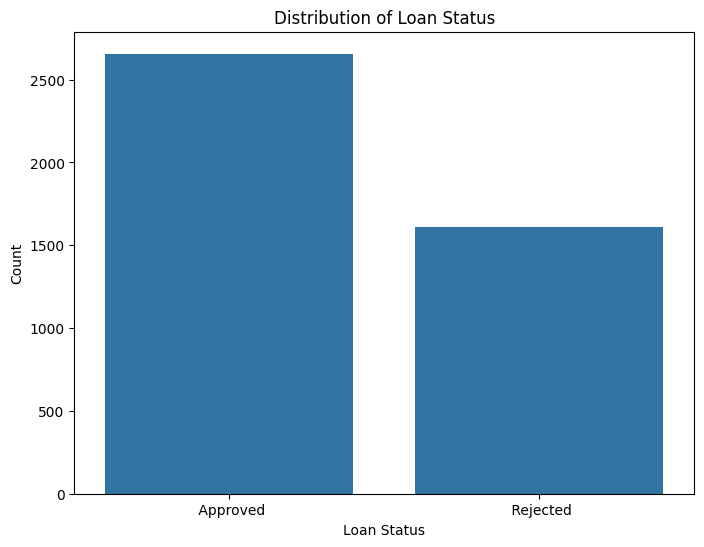

In [137]:
plt.figure(figsize=(8, 6))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Loan Status')


plt.show()

In [138]:
data.isnull().sum()

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

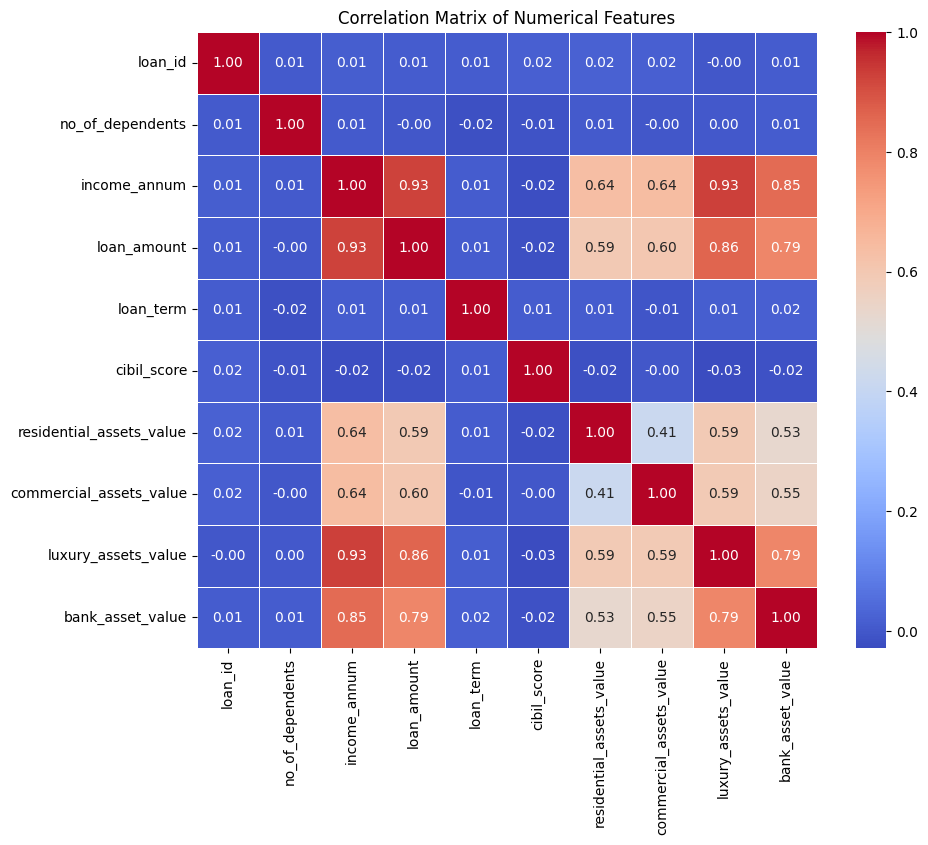

In [139]:
numerical_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_data.corr()

# Set up the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add a title
plt.title("Correlation Matrix of Numerical Features")

# Show the plot
plt.show()

In [140]:
from sklearn.ensemble import RandomForestClassifier

X = data.drop(["loan_status", "loan_id"], axis=1)
y = data["loan_status"]

# Convert categorical variables
X = pd.get_dummies(X, drop_first=True)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
pd.DataFrame(importances)


,0
cibil_score,0.824139
loan_term,0.057374
loan_amount,0.028924
income_annum,0.017512
luxury_assets_value,0.016909
commercial_assets_value,0.015029
residential_assets_value,0.015023
bank_asset_value,0.013652
no_of_dependents,0.006953
self_employed_ Yes,0.002862


#### To determine which numerical features should be considered for classification, we need to combine insights from:

1️⃣ Feature Importance from Random Forest (how much each feature contributes to predicting loan_status).

2️⃣ Correlation Matrix (how strongly features relate to each other, avoiding redundant features).


🚀 Recommended Features for Classification
From feature importance, the top contributors are:

✅ cibil_score (0.82) → Most important feature.

✅ loan_term (0.057) → Has some influence.

✅ loan_amount (0.028) → Slightly relevant.

✅ income_annum (0.017) → Still relevant but weaker.


From the correlation matrix: 🔹 loan_amount and income_annum are highly correlated (~0.93), meaning one of them may be redundant.


🔹 luxury_assets_value, bank_asset_value, commercial_assets_value, and residential_assets_value are moderately correlated with each other and with income (~0.6), suggesting some overlap.


Final Feature Selection
Based on both feature importance & correlation:


🔥 Keep:


cibil_score ✅ (most predictive).

loan_term ✅ (moderately useful).

loan_amount ✅ (slightly more direct impact than income).

residential_assets_value ✅ (best among asset-related features).

⚠️ Consider Dropping (due to high correlation or low importance):


income_annum ❌ (highly correlated with loan_amount).

luxury_assets_value, bank_asset_value, commercial_assets_value ❌ (low importance, redundant with residential_assets_value).

no_of_dependents, self_employed, education ❌ (minimal importance).


In [141]:
selected_numerical_features = ["cibil_score", "loan_amount", "loan_term", "residential_assets_value"]

In [142]:
from scipy.stats import chi2_contingency

# Assuming 'data' is your dataframe and 'loan_approval' is the target variable
# Cross-tabulate the education and employment features with loan approval
contingency_education = pd.crosstab(data['education'], data['loan_status'])
contingency_employment = pd.crosstab(data['self_employed'], data['loan_status'])

# Perform Chi-Square test
chi2_edu, p_edu, _, _ = chi2_contingency(contingency_education)
chi2_emp, p_emp, _, _ = chi2_contingency(contingency_employment)

print(f"Education feature p-value: {p_edu}")
print(f"Employment feature p-value: {p_emp}")


Education feature p-value: 0.7720042291016309
Employment feature p-value: 1.0


In [143]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['education_encoded'] = le.fit_transform(data['education'])
data['employment_encoded'] = le.fit_transform(data['self_employed'])

X = data[['education_encoded', 'employment_encoded']]
y = data['loan_status']

mi = mutual_info_classif(X, y)
print(f"Mutual Information Scores: {mi}")


Mutual Information Scores: [0.01047518 0.        ]


#### Since Chi-Square p-values are high, it suggests that these categorical features may not be very important for loan approval.
#### So no categoerical will be considered for the classification purpose

### Preprocessing

In [144]:
X = data[selected_numerical_features]
y = data["loan_status"]

y

0        Approved
1        Rejected
2        Rejected
3        Rejected
4        Rejected
          ...    
4264     Rejected
4265     Approved
4266     Rejected
4267     Approved
4268     Approved
Name: loan_status, Length: 4269, dtype: object

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)  # Fit on train
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)  # Transform test

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


🔹 Logistic Regression Accuracy: 0.9169
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       536
           1       0.85      0.95      0.89       318

    accuracy                           0.92       854
   macro avg       0.91      0.92      0.91       854
weighted avg       0.92      0.92      0.92       854



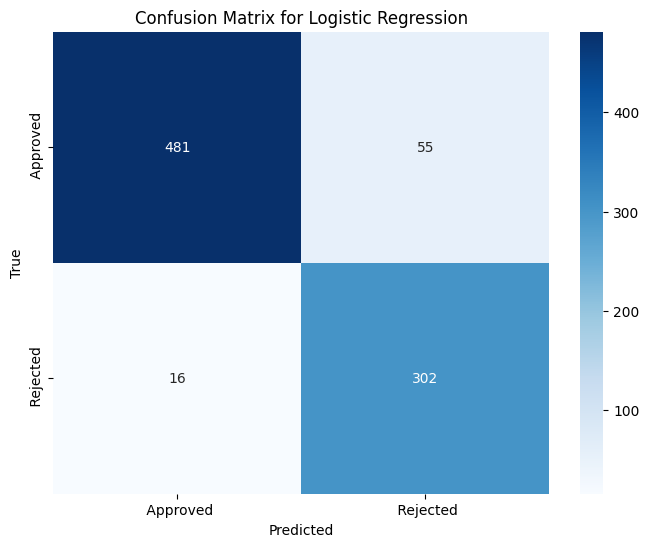


🔹 Random Forest Accuracy: 0.9625
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       536
           1       0.95      0.95      0.95       318

    accuracy                           0.96       854
   macro avg       0.96      0.96      0.96       854
weighted avg       0.96      0.96      0.96       854



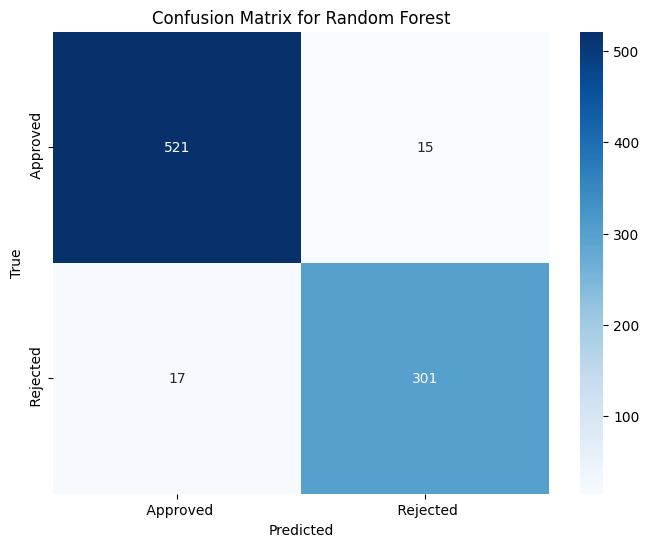


🔹 Gradient Boosting Accuracy: 0.9660
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       536
           1       0.96      0.95      0.95       318

    accuracy                           0.97       854
   macro avg       0.96      0.96      0.96       854
weighted avg       0.97      0.97      0.97       854



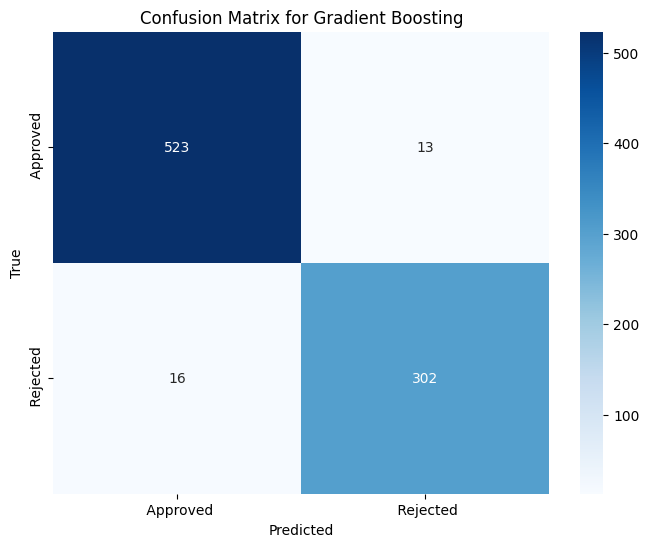


🔹 XGBoost Accuracy: 0.9578
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       536
           1       0.95      0.94      0.94       318

    accuracy                           0.96       854
   macro avg       0.96      0.95      0.95       854
weighted avg       0.96      0.96      0.96       854



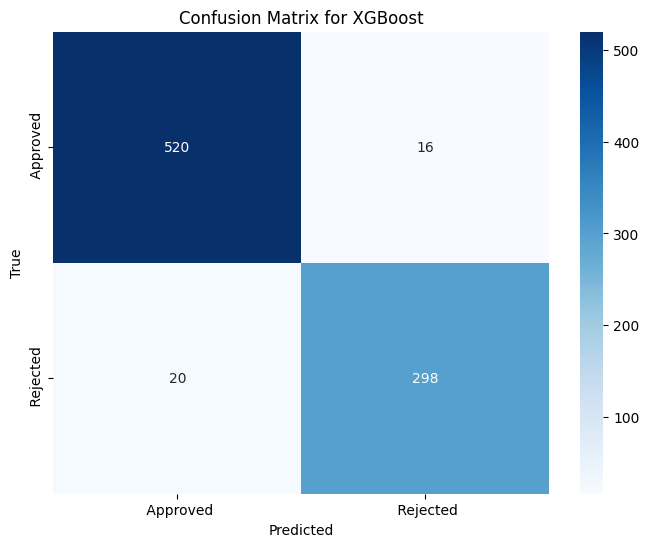

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define models with class weights for handling imbalance
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', scale_pos_weight=2, random_state=42)  # scale_pos_weight adjusts for imbalance
}

# Train and evaluate models
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔹 {name} Accuracy: {acc:.4f}")
    
    # Classification report
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [148]:
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
}

# Perform cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n🔹 {name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



🔹 Logistic Regression Cross-Validation Accuracy: 0.9183 ± 0.0085

🔹 Random Forest Cross-Validation Accuracy: 0.9625 ± 0.0072

🔹 Gradient Boosting Cross-Validation Accuracy: 0.9561 ± 0.0055

🔹 XGBoost Cross-Validation Accuracy: 0.9593 ± 0.0073


In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

print("🔹 Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
🔹 Tuned Random Forest Accuracy: 0.9566744730679156
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       536
           1       0.94      0.94      0.94       318

    accuracy                           0.96       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.96      0.96      0.96       854

